### Deep Learning M2 TIDE - KORAIBI Kamar

**Inception-ResNet-v2** est un réseau de neurones convolutifs entraîné sur plus d'un million d'images de la base de données ImageNet.
Composé de 164 couches et pouvant classer jusqu'à 1000 catégories d'objets.
Il s'agit d'une combinaison de la structure Inception et Residual Connection. L'utilisation des Residual Connections évite non seulement le problème de dégradation causé par les structures profondes, mais réduit également le temps d'entraînement.

In [2]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [3]:
num_classes = 10
input_shape = (32, 32, 3)
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)
datagen.fit(x_train)
datagen_test = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True)
datagen_test.fit(x_train)

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid
    
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(x_train, y_train)

In [5]:
base_model = keras.applications.InceptionResNetV2(
    weights = 'imagenet', # image data set
    include_top = False, # not to include the fully-connected layer at the top of the network
    input_shape = (299,299,3))

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

On remarque qu'il y a 54 millions de paramètres.

In [6]:
inputs = keras.Input(shape = (32,32,3))
input = keras.layers.Lambda(lambda image : tf.image.resize(image,(299,299)))(inputs) # rescaling image

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(500, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(10,activation='softmax')(x)

model = keras.Model(inputs,outputs)

In [8]:
base_model.trainable = False #freezed
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['acc'])

There are many types of callbacks used to interrupt the training process when the validation accuracy (or loss) is no longer improving (***ModelCheckPoint, EarlyStopping, ReduceLRonPlateau***). I am going to use EarlyStopping in this specific problem.

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
                                            patience=5) 
# Patience is the number of epochs with no improvement after which training will be stopped

# we fit the model
history = model.fit(datagen.flow(x_train, y_train), 
                    validation_data=datagen_test.flow(x_valid, y_valid),
                    batch_size=128,
                    validation_steps=50,
                    callbacks=[callback],
                    epochs=20,
                    verbose=1)

Epoch 1/20
1407/1407 [==============================] - 270s 179ms/step - loss: 0.6464 - acc: 0.7798 - val_loss: 0.4184 - val_acc: 0.8569
Epoch 2/20
1407/1407 [==============================] - 249s 177ms/step - loss: 0.5420 - acc: 0.8152 - val_loss: 0.3428 - val_acc: 0.8794
Epoch 3/20
1407/1407 [==============================] - 249s 177ms/step - loss: 0.5128 - acc: 0.8245 - val_loss: 0.3311 - val_acc: 0.8925
Epoch 4/20
1407/1407 [==============================] - 249s 177ms/step - loss: 0.4976 - acc: 0.8280 - val_loss: 0.3099 - val_acc: 0.8925
Epoch 5/20
1407/1407 [==============================] - 249s 177ms/step - loss: 0.4844 - acc: 0.8351 - val_loss: 0.3353 - val_acc: 0.8844
Epoch 6/20
1407/1407 [==============================] - 248s 177ms/step - loss: 0.4677 - acc: 0.8380 - val_loss: 0.2931 - val_acc: 0.8963
Epoch 7/20
1407/1407 [==============================] - 248s 177ms/step - loss: 0.4641 - acc: 0.8392 - val_loss: 0.3019 - val_acc: 0.8956
Epoch 8/20
1407/1407 [============

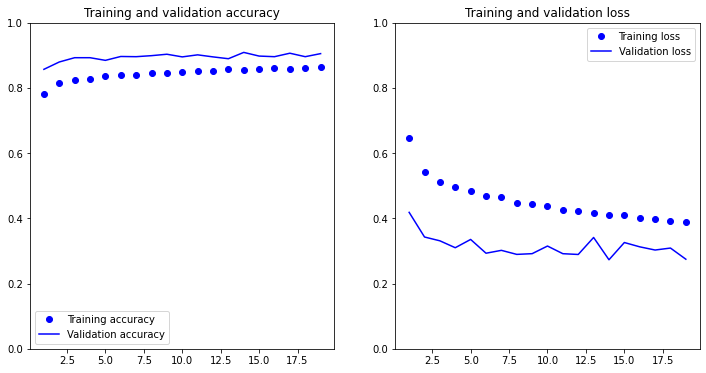

In [22]:
import matplotlib.pyplot as plt

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax.plot(epochs, acc, "bo", label="Training accuracy")
ax.plot(epochs, val_acc, "b", label="Validation accuracy")
ax.set_title("Training and validation accuracy")
ax.set_ylim([0, 1])
ax.legend()

ax2.plot(epochs, loss, "bo", label="Training loss")
ax2.plot(epochs, val_loss, "b", label="Validation loss")
ax2.set_title("Training and validation loss")
ax2.set_ylim([0, 1])
ax2.legend();

### Fine-Tuning
Le *Fine-Tuning* est une façon d'appliquer le *Transfer Learning*. Plus précisément, le fine-tuning est un processus qui prend un modèle qui a déjà été entraîné pour une tâche donnée, puis ajuste le modèle de sorte à effectuer une deuxième tâche similaire. Les étapes* du fine-tuning sont :
1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added.
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.

**Source : 
Deep Learning with Python, 2nd Edition by Francois Chollet (p234)*

I am going to plot the model thanks to the keras plot_model() function:

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='model.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.591003 to fit



Théoriquement, on commence par la partie du dessous qu'on unfreeze et train et on remonte si besoin en fonction de la taille de la base de données et des résultats.

In [11]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed_5b
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 conv2d_12
51 conv2d_14
52 conv2d_17
53 batch_normalization_12
54 batch_normalization_14
55 batch_normalization_17
56 activa

Après quelques essais, j'ai opté pour le noeud numéro 418. Je vais donc unfreeze et entraîner le modèle sur les couches suivant ce noeud.

In [12]:
# freeze
for layer in base_model.layers[:418]:
    layer.trainable=False
# unfreeze
for layer in base_model.layers[418:]:
    layer.trainable=True

In [13]:
# compile using Adam optimizer with very low rate
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(1e-5),
              metrics=['acc'])

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                            patience=5) 

In [15]:
model.fit(datagen.flow(x_train, y_train), 
          validation_data=datagen_test.flow(x_valid, y_valid),
          batch_size=128,
          validation_steps=50,
          epochs=30,
          callbacks=[callback],
          verbose=1)

Epoch 1/30
1407/1407 [==============================] - 257s 176ms/step - loss: 0.3579 - acc: 0.8745 - val_loss: 0.2660 - val_acc: 0.9062
Epoch 2/30
1407/1407 [==============================] - 245s 174ms/step - loss: 0.3385 - acc: 0.8817 - val_loss: 0.2890 - val_acc: 0.9075
Epoch 3/30
1407/1407 [==============================] - 245s 174ms/step - loss: 0.3321 - acc: 0.8834 - val_loss: 0.2839 - val_acc: 0.9087
Epoch 4/30
1407/1407 [==============================] - 247s 175ms/step - loss: 0.3257 - acc: 0.8853 - val_loss: 0.2618 - val_acc: 0.9119
Epoch 5/30
1407/1407 [==============================] - 247s 175ms/step - loss: 0.3194 - acc: 0.8863 - val_loss: 0.2692 - val_acc: 0.9087
Epoch 6/30
1407/1407 [==============================] - 245s 174ms/step - loss: 0.3240 - acc: 0.8862 - val_loss: 0.2793 - val_acc: 0.9050
Epoch 7/30
1407/1407 [==============================] - 245s 174ms/step - loss: 0.3205 - acc: 0.8881 - val_loss: 0.2952 - val_acc: 0.9006
Epoch 8/30
1407/1407 [============

In [23]:
print("Test Accuracy: ",model.evaluate(datagen_test.flow(x_test,y_test))[1]) # 0.9027

313/313 [==============================] - 53s 168ms/step - loss: 0.2953 - acc: 0.9027
Test Accuracy:  0.9027000069618225
